In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler #, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

cluster_candidates = pd.read_csv('../PleiadesTidalTails/data/clean.csv')
del cluster_candidates['Unnamed: 0']

ra_mean = np.median(cluster_candidates['ra'])
dec_mean = np.median(cluster_candidates['dec'])
pmra_mean = np.median(cluster_candidates['pmra'])
pmdec_mean = np.median(cluster_candidates['pmdec'])

cluster_candidates['angular_distance'] = np.sqrt((cluster_candidates['ra'] - ra_mean)**2 + (cluster_candidates['dec'] - dec_mean)**2)
cluster_candidates['pm_relative'] = np.sqrt((cluster_candidates['pmra'] - pmra_mean)**2 + (cluster_candidates['pmdec'] - pmdec_mean)**2)

scaler_astrometry = StandardScaler()
scaler_rv = StandardScaler()

# cluster_candidates[['ra','dec','pmra','pmdec','parallax']] = \
#     scaler_astrometry.fit_transform(cluster_candidates[['ra','dec','pmra','pmdec','parallax']])
# cluster_candidates[['radial_velocity']] = scaler_rv.fit_transform(cluster_candidates[['radial_velocity']])

print(len(cluster_candidates))

cluster_candidates_rv = cluster_candidates[~cluster_candidates['radial_velocity'].isna()]
#cluster_candidates_rv = cluster_candidates_rv[~cluster_candidates_rv['radial_velocity_error'].isna()]
print(len(cluster_candidates_rv))
# cluster_candidates_rv = cluster_candidates_rv[(np.abs(cluster_candidates_rv['radial_velocity']) \
#                                                <= 1.7*np.std(cluster_candidates_rv['radial_velocity']))]
cluster_candidates_rv.info()

1502
509
<class 'pandas.core.frame.DataFrame'>
Index: 509 entries, 0 to 1500
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   level_0                     509 non-null    int64  
 1   index                       509 non-null    int64  
 2   source_id                   509 non-null    int64  
 3   ra                          509 non-null    float64
 4   ra_error                    509 non-null    float64
 5   dec                         509 non-null    float64
 6   dec_error                   509 non-null    float64
 7   l                           509 non-null    float64
 8   b                           509 non-null    float64
 9   parallax                    509 non-null    float64
 10  parallax_error              509 non-null    float64
 11  pmra                        509 non-null    float64
 12  pmra_error                  509 non-null    float64
 13  pmdec                       50

In [17]:
# cluster_candidates_rv[['radial_velocity','radial_velocity_error','ra','dec','pmra','pmdec','parallax']] = \
#     StandardScaler().fit_transform(cluster_candidates_rv[['radial_velocity','radial_velocity_error','ra','dec','pmra','pmdec','parallax']])

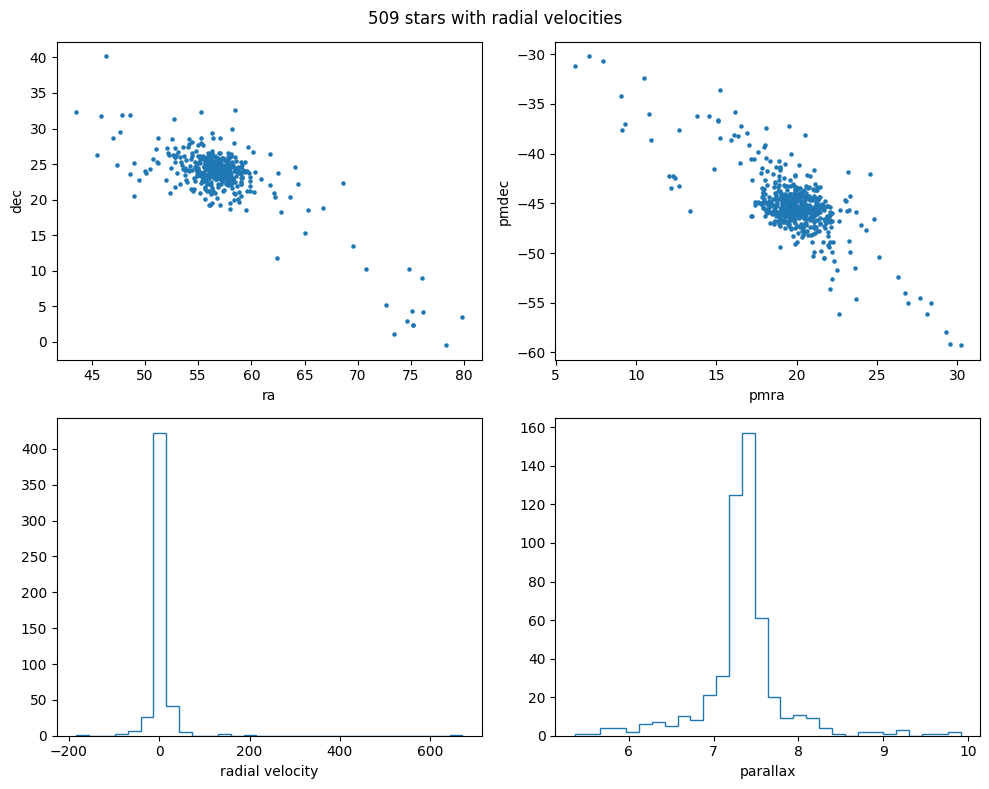

In [2]:
fig, ax = plt.subplots(2,2, figsize=(10,8))

fig.suptitle('%s stars with radial velocities'%len(cluster_candidates_rv))

ax[0,0].scatter(cluster_candidates_rv['ra'], cluster_candidates_rv['dec'], s=5)
ax[0,0].set_xlabel('ra')
ax[0,0].set_ylabel('dec')

ax[0,1].scatter(cluster_candidates_rv['pmra'], cluster_candidates_rv['pmdec'], s=5)
ax[0,1].set_xlabel('pmra')
ax[0,1].set_ylabel('pmdec')

ax[1,0].hist(cluster_candidates_rv['radial_velocity'], bins=30, density=False, histtype='step')
ax[1,0].set_xlabel('radial velocity')

ax[1,1].hist(cluster_candidates_rv['parallax'], bins=30, histtype='step', density=False)
ax[1,1].set_xlabel('parallax')
fig.tight_layout()
plt.show()

In [3]:
len(cluster_candidates), len(cluster_candidates_rv)

(1502, 509)

In [4]:
# fig, ax = plt.subplots(2,2, figsize=(10,8))

# fig.suptitle('stars with radial velocities')

# ax[0,0].scatter(cluster_candidates_rv['angular_distance'], cluster_candidates_rv['radial_velocity'], s=5)
# ax[0,0].set_xlabel('angular_distance')
# ax[0,0].set_ylabel('radial_velocity')

# ax[0,1].scatter(cluster_candidates_rv['pm_relative'], cluster_candidates_rv['radial_velocity'], s=5)
# ax[0,1].set_xlabel('pm_relative')
# ax[0,1].set_ylabel('radial_velocity')

# ax[1,0].hist(cluster_candidates_rv['distance'], bins=30, histtype='step', density=False)
# ax[1,0].set_xlabel('distance')

# ax[1,1].hist(cluster_candidates_rv['radial_velocity'], bins=30, density=False, histtype='step')
# ax[1,1].set_xlabel('radial velocity')

# fig.tight_layout()
# plt.show()

Training shape: (509, 4) (509, 1)
Full shape: (1502, 4)


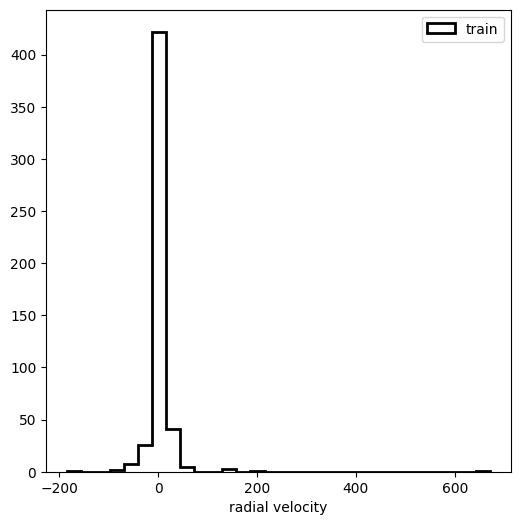

In [2]:
x_data = np.array(cluster_candidates_rv[['ra','dec','pmra','pmdec']])
x_full = np.array(cluster_candidates[['ra','dec','pmra','pmdec']])
y_data = np.array(cluster_candidates_rv[['radial_velocity']])

#x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=42)
x_train, y_train = x_data, y_data

print('Training shape:', x_train.shape, y_train.shape)
print('Full shape:', x_full.shape)

plt.figure(figsize=(6,6))
plt.hist(y_train, bins=30, density=False, histtype='step', label='train', lw=2, color='k')
plt.legend()
plt.xlabel('radial velocity')
plt.show()

# SVR

In [7]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [10]:
from sklearn.svm import SVR

param_grid = {
    'C': np.linspace(1, 10, 10).tolist(),
    'kernel': ['linear','rbf','poly'],
    'gamma': [0.1, 1, 'scale', 'auto']
}

svr = SVR()
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5) # 106 minutes
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

best params:  {'C': 10.0, 'gamma': 'scale', 'kernel': 'poly'}
best model SVR(C=10.0, kernel='poly')


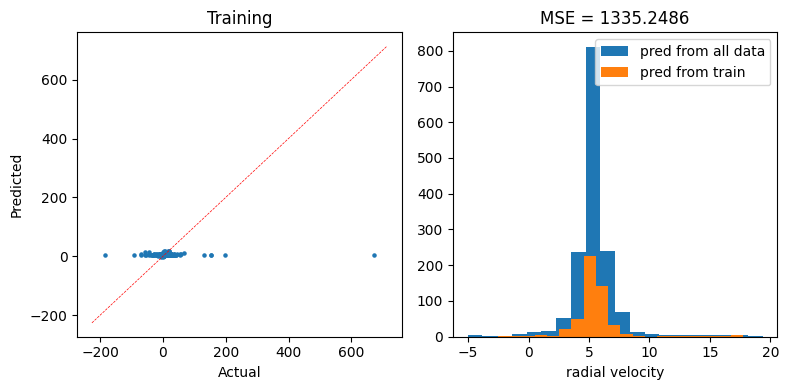

In [17]:
print('best params: ', best_params) 
print('best model', best_model)

# Evaluate the model
y_train_pred = best_model.predict(x_train)
y_full_pred = best_model.predict(x_full)

fig, ax = plt.subplots(1,2, figsize=(8,4))

ax[0].scatter(y_train, y_train_pred, s=5)
ax[0].set_xlabel("Actual", fontsize=10)
ax[0].set_ylabel("Predicted",  fontsize=10)
ax[0].set_title("Training")
x = np.linspace(*ax[0].get_xlim())
ax[0].plot(x, x, color='red', ls='--', lw=0.5)

ax[1].set_title('MSE = {:.4f}'.format(mean_squared_error(y_data, y_train_pred)))
ax[1].hist(y_full_pred, bins=20, label='pred from all data')
ax[1].hist(y_train_pred, bins=20, label='pred from train')
ax[1].set_xlabel("radial velocity")
ax[1].legend()
fig.tight_layout()
plt.show()

# Gaussian regression

0.002381557232853715


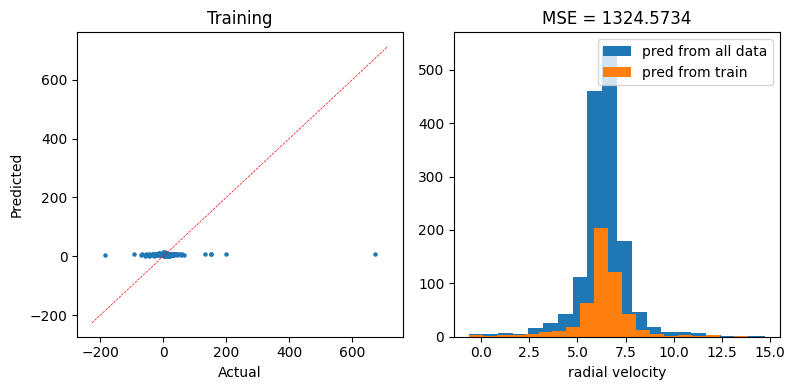

In [18]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=33).fit(x_train, y_train)
print(gpr.score(x_train, y_train))
y_train_pred = gpr.predict(x_train)
y_full_pred = gpr.predict(x_full)

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].scatter(y_train, y_train_pred, s=5)
ax[0].set_xlabel("Actual", fontsize=10)
ax[0].set_ylabel("Predicted",  fontsize=10)
ax[0].set_title("Training")
x = np.linspace(*ax[0].get_xlim())
ax[0].plot(x, x, color='red', ls='--', lw=0.5)

ax[1].set_title('MSE = {:.4f}'.format(mean_squared_error(y_data, y_train_pred)))
ax[1].hist(y_full_pred, bins=20, label='pred from all data')
ax[1].hist(y_train_pred, bins=20, label='pred from train')
ax[1].set_xlabel("radial velocity")
ax[1].legend()
fig.tight_layout()
plt.show()

# non-parametric regression

In [33]:
#import statsmodels.api as sm
from sklearn.kernel_ridge import KernelRidge

#smoothed = sm.nonparametric.lowess(exog=x_data, endog=y_data, frac=0.15, is_sorted=False)
# 'cosine', 'linear', 'poly', 'chi2', 'additive_chi2', 'rbf', 'laplacian', 'sigmoid', 'polynomial', 'precomputed'

#clf = KernelRidge(kernel='rbf', gamma=5.0, alpha=.01)

param_grid = {
    'gamma': np.linspace(1, 20, 50).tolist(),
    'kernel': ['linear','rbf','poly'],
    'alpha': np.linspace(0.005, 0.5, 20).tolist(),
    'degree': [1, 2, 3, 4]
}

clf = KernelRidge()
grid_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter=20, cv=30) #  minutes
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

best params:  {'kernel': 'linear', 'gamma': 19.224489795918366, 'degree': 4, 'alpha': 0.3957894736842105}
best model KernelRidge(alpha=0.3957894736842105, degree=4, gamma=19.224489795918366)


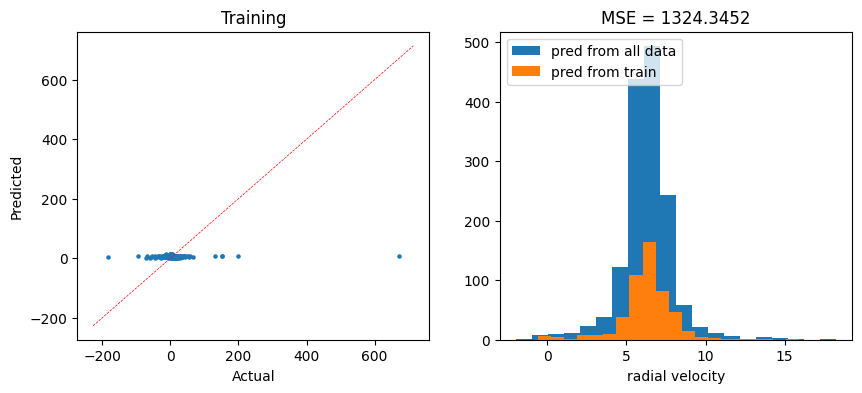

In [34]:
print('best params: ', best_params) 
print('best model', best_model)

# Evaluate the model
y_train_pred = best_model.predict(x_train)
y_full_pred = best_model.predict(x_full)

fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].scatter(y_data, y_train_pred, s=5)
ax[0].set_xlabel("Actual", fontsize=10)
ax[0].set_ylabel("Predicted",  fontsize=10)
ax[0].set_title("Training")
x = np.linspace(*ax[0].get_xlim())
ax[0].plot(x, x, color='red', ls='--', lw=0.5)

ax[1].set_title('MSE = {:.4f}'.format(mean_squared_error(y_data, y_train_pred)))
ax[1].hist(y_full_pred, bins=20, label='pred from all data')
ax[1].hist(y_train_pred, bins=20, label='pred from train')
ax[1].set_xlabel("radial velocity", fontsize=10)
ax[1].legend(loc=2)
fig.show()

In [ ]:
# import statsmodels.api as sm

# smoothed = sm.nonparametric.lowess(exog=x_data, endog=y_data, frac=0.15, is_sorted=False)
# # 'cosine', 'linear', 'poly', 'chi2', 'additive_chi2', 'rbf', 'laplacian', 'sigmoid', 'polynomial', 'precomputed'

# #smoothed[:, 0], 
# y_full_pred = smoothed[:, 1]

# y_pred_train = clf.predict(x_data)
# y_full_pred = clf.predict(x_full)

# fig, ax = plt.subplots(1,2, figsize=(10,4))

# ax[0].scatter(y_data, y_pred_train, s=5)
# ax[0].set_xlabel("Actual", fontsize=10)
# ax[0].set_ylabel("Predicted",  fontsize=10)
# ax[0].set_title("Training")
# x = np.linspace(*ax[0].get_xlim())
# ax[0].plot(x, x, color='red', ls='--', lw=0.5)

# ax[1].set_title('MSE = {:.4f}'.format(mean_squared_error(y_data, y_pred_train)))
# ax[1].hist(y_full_pred, bins=20, label='pred from all data')
# ax[1].hist(y_pred_train, bins=20, label='pred from train')
# ax[1].set_xlabel("radial velocity", fontsize=10)
# ax[1].legend(loc=2)
# fig.show()

# Neural Network

In [3]:
import tensorflow as tf
#tensorflow.random.set_seed(1234)
from tensorflow import keras
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Dropout, Input#, BatchNormalization
from sklearn.metrics import mean_absolute_error
from functools import partial

import keras_tuner as kt

2024-09-12 11:56:06.372109: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-12 11:56:07.209543: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-12 11:56:07.210425: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-12 11:56:11.181607: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [36]:
#!pip install -q -U keras-tuner

/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point


In [56]:
tf.keras.backend.clear_session()

In [4]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.Input(shape=x_train.shape[1],))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=200, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(1, activation='linear'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss=keras.losses.MeanSquaredError(), metrics=['mse'])

  return model

In [5]:
tuner = kt.Hyperband(model_builder, objective='mse', max_epochs=100, factor=3)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=5)

Reloading Tuner from ./untitled_project/tuner0.json


In [6]:
tuner.search(x_train, y_train, epochs=100, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [7]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 96 and the optimal learning rate for the optimizer
is 0.001.



In [48]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=50)

val_acc_per_epoch = history.history['mse']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
16/16 [==============================] - 0s 1ms/step - loss: 1355.2589 - mse: 1355.2589
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 1345.2012 - mse: 1345.2012
Epoch 3/50
16/16 [==============================] - 0s 2ms/step - loss: 1333.3065 - mse: 1333.3065
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 1329.6587 - mse: 1329.6587
Epoch 5/50
16/16 [==============================] - 0s 1ms/step - loss: 1326.2026 - mse: 1326.2026
Epoch 6/50
16/16 [==============================] - 0s 1ms/step - loss: 1326.2170 - mse: 1326.2170
Epoch 7/50
16/16 [==============================] - 0s 1ms/step - loss: 1327.2601 - mse: 1327.2601
Epoch 8/50
16/16 [==============================] - 0s 2ms/step - loss: 1325.4657 - mse: 1325.4657
Epoch 9/50
16/16 [==============================] - 0s 2ms/step - loss: 1327.8861 - mse: 1327.8861
Epoch 10/50
16/16 [==============================] - 0s 2ms/step - loss: 1328.3774 - mse: 1328.3774
Epoch 11/

In [49]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(x_train, y_train, epochs=best_epoch)

16/16 [==============================] - 0s 2ms/step - loss: 1457.2474 - mse: 1457.2474


In [50]:
eval_result = hypermodel.evaluate(x_train, y_train)
print("[test loss, test accuracy]:", eval_result)

16/16 [==============================] - 0s 1ms/step - loss: 1334.0983 - mse: 1334.0983
[test loss, test accuracy]: [1334.0982666015625, 1334.0982666015625]


47/47 [==============================] - 0s 762us/step


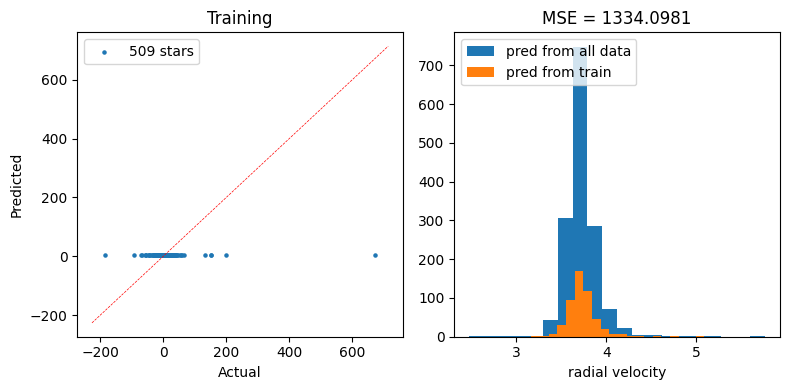

In [51]:
y_train_pred = hypermodel.predict(x_train).flatten()
y_full_pred = hypermodel.predict(x_full).flatten()

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].scatter(y_train, y_train_pred, s=5, label='%s stars'%len(y_train))
ax[0].set_xlabel("Actual", fontsize=10)
ax[0].set_ylabel("Predicted",  fontsize=10)
ax[0].set_title("Training")
x = np.linspace(*ax[0].get_xlim())
ax[0].plot(x, x, color='red', ls='--', lw=0.5)
ax[0].legend()

ax[1].set_title('MSE = {:.4f}'.format(mean_squared_error(y_data, y_train_pred)))
ax[1].hist(y_full_pred, bins=20, label='pred from all data')
ax[1].hist(y_train_pred, bins=20, label='pred from train')
ax[1].set_xlabel("radial velocity", fontsize=10)
ax[1].legend(loc=2)

fig.tight_layout()
plt.show()

In [41]:
# initializer = tensorflow.keras.initializers.glorot_uniform(seed=1)
# kernel_initializer=initializer

# model = Sequential([
#     Input(shape=(x_train.shape[1],)),
#     Dense(50, activation='relu'),
#     Dense(100, activation='relu'),
#     #BatchNormalization(),
#     #Dense(200, activation='relu'), # kernel_regularizer=tensorflow.keras.regularizers.L2(0.001)
#     Dropout(0.2),
#     Dense(100, activation='relu'),
#     #BatchNormalization(),
#     Dense(50, activation='relu'),
#     Dense(1, activation='linear')
# ])

# alpha_relu = 0.01
# model = Sequential([
#     Input(shape=(x_train.shape[1],)),
#     Dense(30, activation=partial(tensorflow.nn.leaky_relu, alpha=alpha_relu)),
#     #Dense(30, activation=partial(tensorflow.nn.leaky_relu, alpha=alpha_relu)),
#     Dense(100, activation=partial(tensorflow.nn.leaky_relu, alpha=alpha_relu)),
#     Dropout(0.3),
#     Dense(100, activation=partial(tensorflow.nn.leaky_relu, alpha=alpha_relu)),
#     #Dense(30, activation=partial(tensorflow.nn.leaky_relu, alpha=alpha_relu)),
#     Dense(30, activation=partial(tensorflow.nn.leaky_relu, alpha=alpha_relu)),
#     Dense(1, activation='linear')
# ])

# model = Sequential([
#     Input(shape=(x_train.shape[1],)),
#     Dense(100, activation='relu'),
#     Dropout(0.2),
#     Dense(200, activation='relu'),
#     Dropout(0.2),
#     Dense(100, activation='relu'),
#     Dense(1, activation='linear')
# ])

# partial(tensorflow.nn.leaky_relu, alpha=0.01)
# model = Sequential([
#     Input(shape=(x_train.shape[1],)),
#     Dense(100, activation='relu'), # kernel_initializer=initialize
#     Dense(200, activation='relu',  kernel_regularizer=tensorflow.keras.regularizers.L2(0.001)),
#     Dropout(0.2),
#     #Dense(100, activation='relu'),
#     #Dropout(0.2),
#     Dense(50, activation='relu'),
#     Dense(1, activation='linear')
# ])

#model.summary()

In [64]:
# def LikelihoodLossFunction(y_true, y_pred):
#     # shape of y_pred should be (nsamples, 2)
#     # the first column should be the line-of-sight velocity
#     # the second column is the uncertainty
#     SIGMA = K.abs(y_pred[:, 1]) + 1e-6
#     LOC = y_pred[:, 0]
#     X = y_true[:, 0]
#     weights = y_true[:,1]
#     ARG = K.pow((X - LOC),2) / (2 * K.pow(SIGMA,2))
#     PREFACT = K.log(K.pow(2 * np.pi * K.pow(SIGMA,2), -0.5))
#     return K.mean((ARG - PREFACT) * weights)

# def custom_loss_(y_true, y_pred):
#     return tensorflow.reduce_mean(tensorflow.square(y_true - y_pred))

# def custom_loss(y_true, y_pred):
#     v_los =  y_true[:,0]
#     sigma_los = y_true[:,1]
#     v_los_pred = y_pred[:,0]
#     ARG = tensorflow.pow((v_los - v_los_pred), 2) / (2 * tensorflow.pow(sigma_los, 2))
#     PREFACT = tensorflow.math.log(tensorflow.pow(2 * np.pi * tensorflow.pow(sigma_los, 2), -0.5))
#     return tensorflow.reduce_mean(ARG - PREFACT)

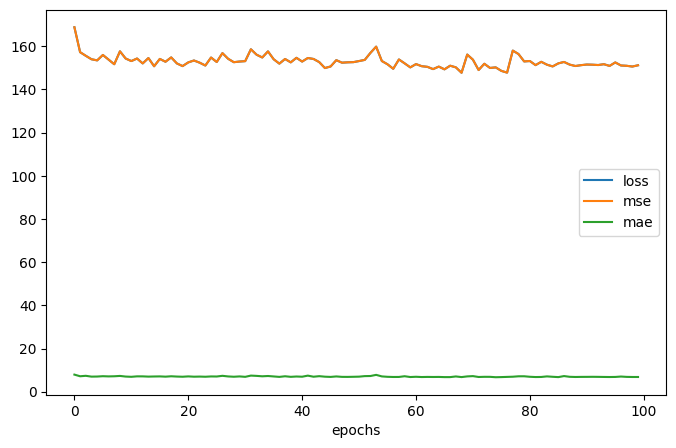

In [25]:
#metrics = ['mean_squared_error', tensorflow.keras.losses.MAE, tensorflow.keras.metrics.R2Score()]
#model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), loss=custom_loss, metrics=['mse'])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse','mae'])
#model.compile(optimizer=tensorflow.keras.optimizers.Adam(), loss=tensorflow.keras.losses.MeanAbsolutePercentageError(), metrics=['mse','mae'])
#model.compile(optimizer=tensorflow.keras.optimizers.Adam(), loss=tensorflow.keras.losses.MeanAbsoluteError(), metrics=['mse','mae'])
history = model.fit(x_train, y_train, epochs=100, batch_size=30, verbose=0) #validation_data=(x_test, y_test)

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.xlabel('epochs')
plt.show()

47/47 [==============================] - 0s 1ms/step


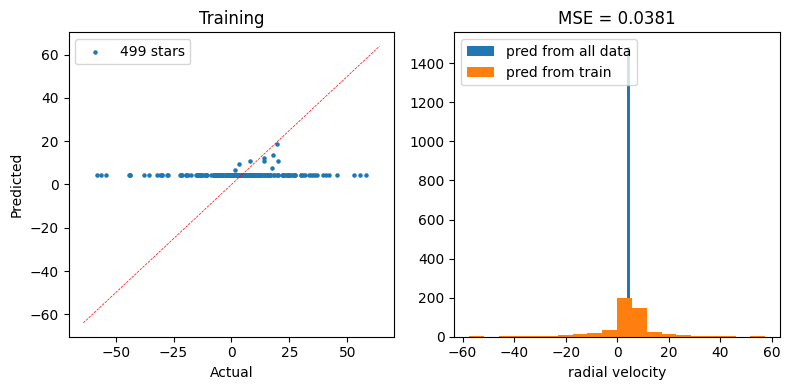

In [26]:
y_train_pred = model.predict(x_train).flatten()
y_full_pred = model.predict(x_full).flatten()

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].scatter(y_train, y_train_pred, s=5, label='%s stars'%len(y_train))
ax[0].set_xlabel("Actual", fontsize=10)
ax[0].set_ylabel("Predicted",  fontsize=10)
ax[0].set_title("Training")
x = np.linspace(*ax[0].get_xlim())
ax[0].plot(x, x, color='red', ls='--', lw=0.5)
ax[0].legend()

ax[1].set_title('MSE = {:.4f}'.format(mean_squared_error(y_data, y_pred_train)))
ax[1].hist(y_full_pred, bins=20, label='pred from all data')
ax[1].hist(y_pred_train, bins=20, label='pred from train')
ax[1].set_xlabel("radial velocity", fontsize=10)
ax[1].legend(loc=2)

fig.tight_layout()
plt.show()

In [ ]:
# cluster_candidates[['radial_velocity','radial_velocity_error','ra','dec','pmra','pmdec','parallax']] = \
#     scaler.inverse_transform(cluster_candidates[['radial_velocity','radial_velocity_error','ra','dec','pmra','pmdec','parallax']])